In [1]:
import numpy as np
import scipy as sp
import sklearn as skl
import skimage as ski
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
dataset = Path("Y:/kau/диплом/data/dataset")
workdir = Path("Y:/kau/диплом/data/run02")

os.makedirs(workdir, exist_ok=True)

In [3]:
descriptors = list(dataset.glob("hist_*.npy"))
descriptors

[WindowsPath('Y:/kau/диплом/data/dataset/hist_R1_P8_d.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R1_P8_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R2_P12_d.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R2_P12_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R3_P24_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R5_P36_u.npy')]

In [4]:
descriptor = 'hist_R1_P8_d'

In [23]:
chunksize = 100

In [5]:
y = np.load(f"{dataset}/labels.npy")
print(y.shape, y.dtype)
label = y[:,1]
label_subset = y[:,0]

(1950, 2) uint8


# Descriptor hist_R1_P8_d

## 1. Mean

In [6]:
X = np.load(f"{dataset}/{descriptor}.npy")
X.shape, X.dtype

((1950, 256), dtype('uint32'))

In [7]:
unique_labels, label_sizes = np.unique(label, return_counts=True)
unique_labels, label_sizes

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=uint8),
 array([150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]))

features stratified by class/label

In [8]:
X_cl = np.array([ X[label == k] for k in unique_labels ])
X_cl.shape, X_cl.dtype

((13, 150, 256), dtype('uint32'))

mean histogram for each class

In [9]:
means = X_cl.mean(axis=1)
means.shape, means.dtype

((13, 256), dtype('float64'))

In [22]:
np.save(workdir / 'X_cl.npy', X_cl)
np.save(workdir / 'means.npy', means)

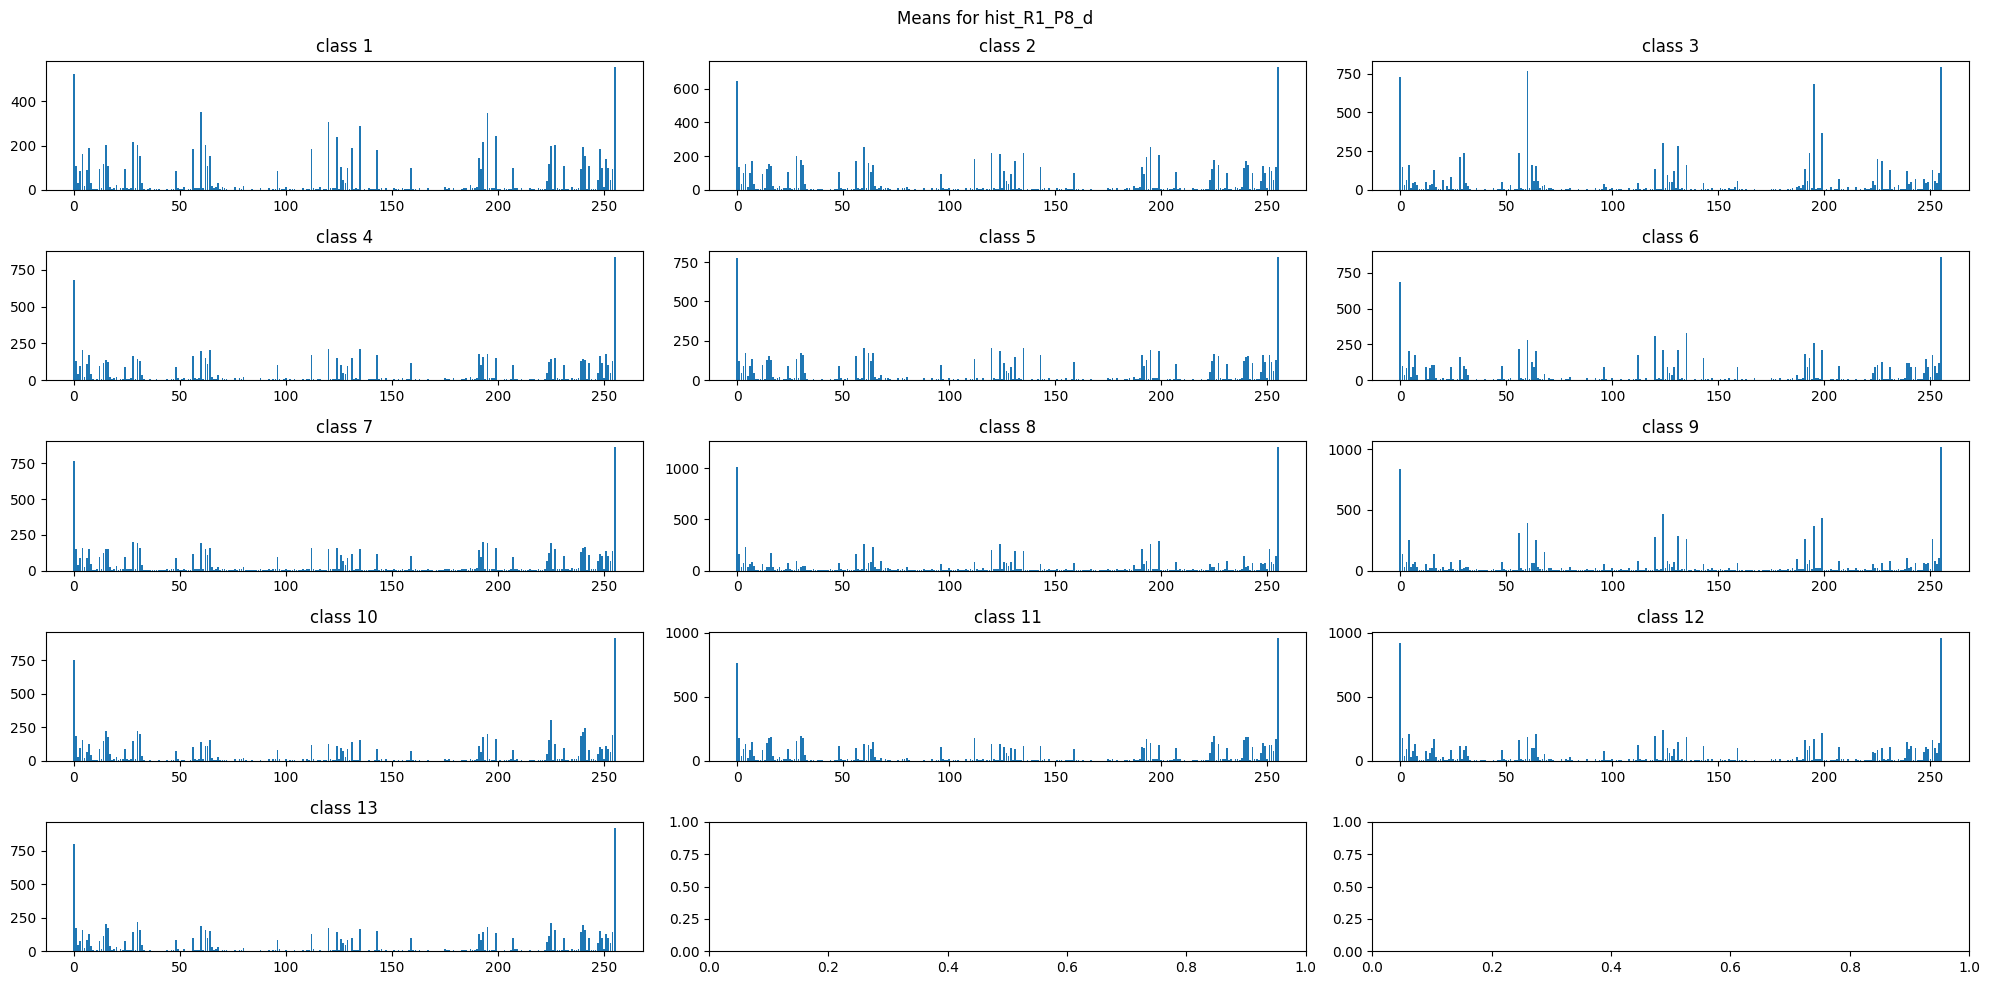

In [20]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    ax.bar(range(means.shape[1]), means[k])
    ax.set_title(f'class {k+1}')
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'Means for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

### Some descriptive stats for mean histograms

In [14]:
print("Min:", means.min(axis=1))
print("Max:", means.max(axis=1))
print("Sum:", means.sum(axis=1))

Min: [0.08       0.12       0.11333333 0.12       0.08666667 0.22666667
 0.17333333 0.38666667 0.3        0.33333333 0.12666667 0.22
 0.24666667]
Max: [ 556.05333333  730.07333333  795.45333333  836.16        781.52
  860.02        862.14       1201.39333333 1015.05333333  915.09333333
  959.72        958.86        918.47333333]
Sum: [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000.]


### CDF

In [24]:
means_cdf = means.cumsum(axis=1) / (chunksize**2)

# Sanity check -- this is a histogram and P = 1.0 for last item
assert (np.abs(means_cdf[:,-1] - 1) < 1e-5).all()

means_cdf.shape, means_cdf.dtype, means_cdf.max()

((13, 256), dtype('float64'), np.float64(1.0000000000000004))

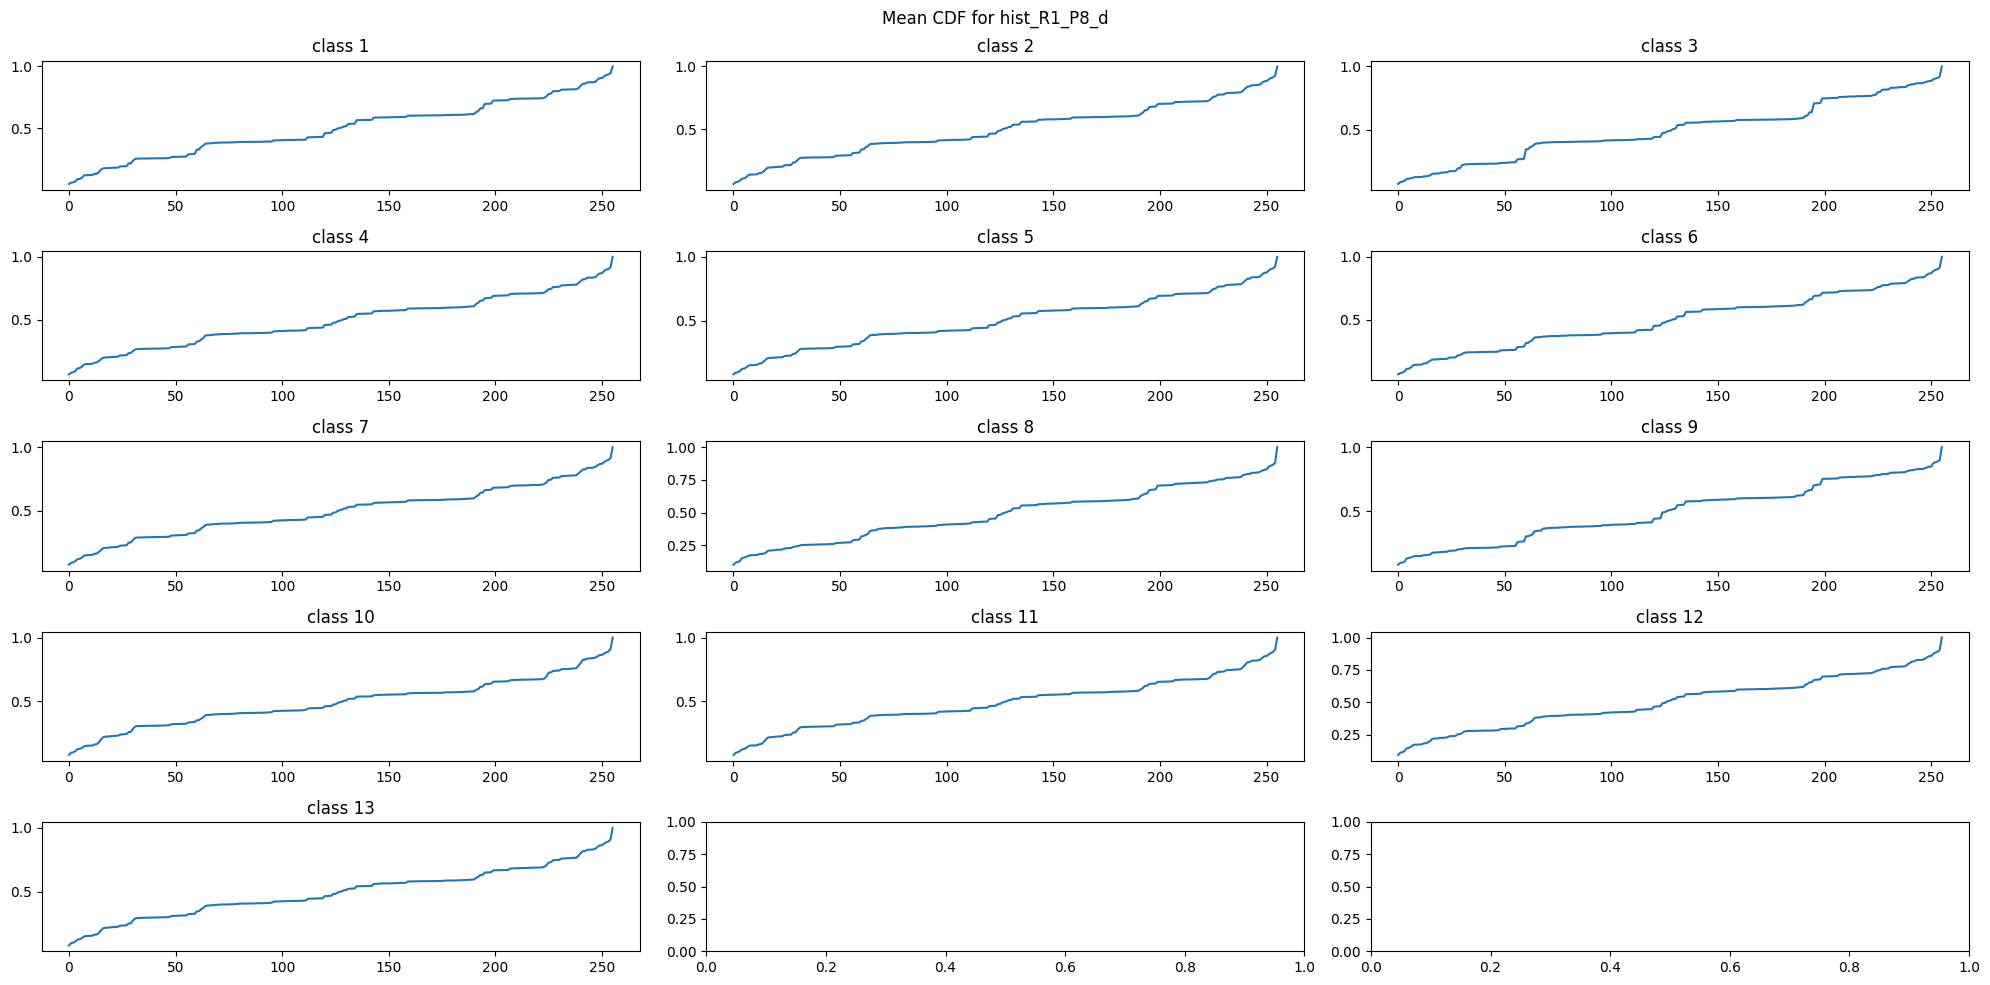

In [19]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    ax.plot(range(means_cdf.shape[1]), means_cdf[k], '-')
    ax.set_title(f'class {k+1}')
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'Mean CDF for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

### Most abundand features

In [ ]:
# means_int = means.astype(np.uint32)
sorted_means = np.ascontiguousarray(np.sort(means, axis=1)[:, ::-1]) / (chunksize**2)   # descending order
sorted_means.shape, sorted_means.dtype

((13, 256), dtype('float64'))

In [33]:
sorted_means_cdf = sorted_means.cumsum(axis=1)
sorted_means_cdf.shape, sorted_means_cdf.dtype

((13, 256), dtype('float64'))

In [34]:
sorted_means_cdf.max(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

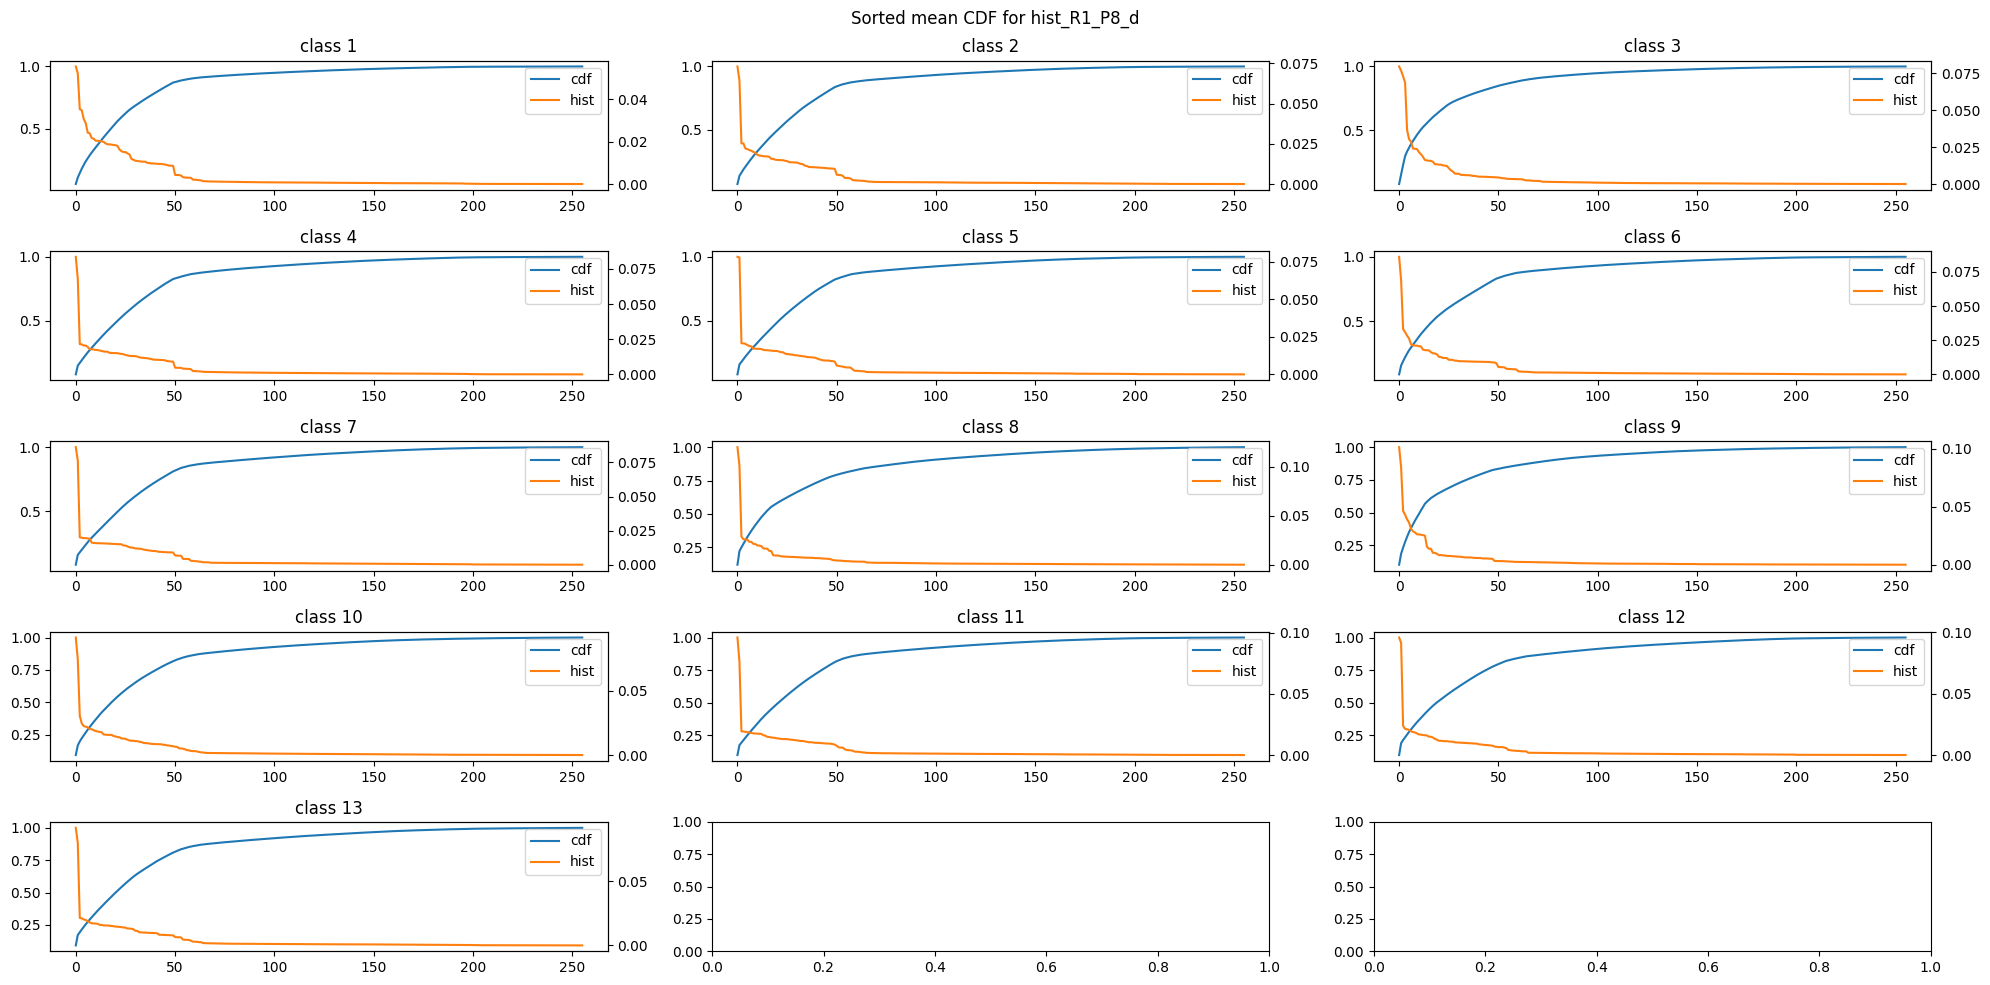

In [45]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    a, = ax.plot(range(sorted_means_cdf.shape[1]), sorted_means_cdf[k], '-', color='C0', label='cdf')
    b, = ax.twinx().plot(range(sorted_means_cdf.shape[1]), sorted_means[k], '-', color='C1', label='hist')
    ax.set_title(f'class {k+1}')
    ax.legend(handles=[a,b])
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'Sorted mean CDF for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

В цілому достатньо 50 фіч, але це перевіримо пізніше

## 2. Normality

In [48]:
# Відхилення кожного спостереження від середнього
delta = np.array([ X_cl[k] - means[k] for k in range(13) ])
delta.shape, delta.dtype

((13, 150, 256), dtype('float64'))

In [74]:
alpha = 0.05
print("Number of likely normal features using D’Agostino, R. and Pearson, E. S. test")
for k in range(13):
    s, pvals = sp.stats.normaltest(delta[k], axis=0)
    res = (pvals > alpha).sum()
    print(f"Class {k+1:2}: {res:3}/{delta.shape[-1]}")

Number of likely normal features using D’Agostino, R. and Pearson, E. S. test
Class  1:  64/256
Class  2: 120/256
Class  3:  25/256
Class  4: 102/256
Class  5:  86/256
Class  6:  96/256
Class  7: 113/256
Class  8:  50/256
Class  9:  53/256
Class 10:  57/256
Class 11: 119/256
Class 12: 114/256
Class 13:  97/256


In [75]:
alpha = 0.05
print("Number of likely normal features using Shapiro-Wilk test")
for k in range(13):
    s, pvals = sp.stats.shapiro(delta[k], axis=0)
    res = (pvals > alpha).sum()
    print(f"Class {k+1:2}: {res:3}/{delta.shape[-1]}")

Number of likely normal features using Shapiro-Wilk test
Class  1:  26/256
Class  2:  51/256
Class  3:   5/256
Class  4:  43/256
Class  5:  39/256
Class  6:  48/256
Class  7:  54/256
Class  8:  24/256
Class  9:  26/256
Class 10:  24/256
Class 11:  52/256
Class 12:  58/256
Class 13:  46/256


## 3. Distribution similarity

### 3.1. Between classes

In [79]:
means_norm = means / (chunksize**2)

In [96]:
# how class j is similar to class i
class_similarity = np.zeros((13,13), dtype=np.float64)
class_similarity_p = np.zeros((13,13), dtype=np.float64)

alpha = 0.05
for c1 in tqdm(range(13)): 
    for c2 in tqdm(range(13), desc="> "):
        if c1 == c2: continue
        stat, pval = sp.stats.power_divergence(f_obs=means[c2], f_exp=means[c1], lambda_='log-likelihood')
        class_similarity[c1,c2] = stat
        class_similarity_p[c1,c2] = pval

100%|██████████| 13/13 [00:00<00:00, 101.44it/s]


In [77]:
import seaborn as sb

<Axes: >

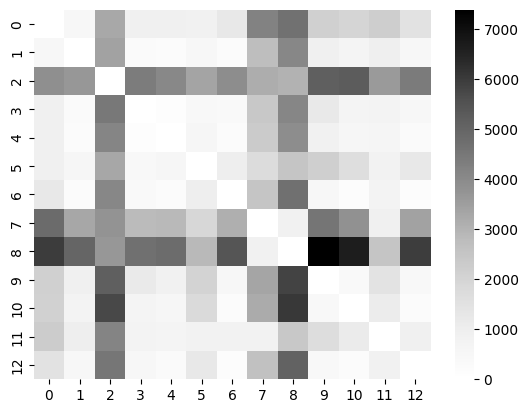

In [97]:
sb.heatmap(class_similarity, cmap='Greys')

Text(0.5, 1.0, 'hist_R1_P8_d\np-value for log-L dist similarity test between classes')

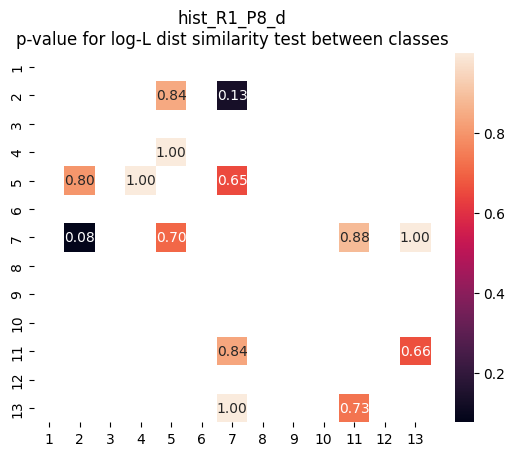

In [107]:
p_mask = class_similarity_p < alpha
sb.heatmap(class_similarity_p, annot=True, fmt=".2f", mask=p_mask, xticklabels=range(1,14), yticklabels=range(1,14))
plt.title(
    f"{descriptor}\n"
    "p-value for log-L dist similarity test between classes"
)

## 4. Performance

In [166]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, label, test_size=0.4, random_state=2225, stratify=label)
X_train.shape, y_train.shape

((1170, 256), (1170,))

In [167]:
unique_labels, label_sizes = np.unique(y_train, return_counts=True)
X_train_cl = np.array([ X_train[y_train == k] for k in unique_labels])
means_train = X_train_cl.mean(axis=1) + 1   # +1 to avoid small values

In [168]:
def predict_naive(x):
    # x should be a non-normed histogram
    distances, pvalues = sp.stats.power_divergence( f_obs=(x+1), f_exp=means_train, axis=1, lambda_='log-likelihood')
    assert len(distances) == len(unique_labels)
    return unique_labels[np.argmin(distances)]

In [169]:
pred_classes = np.zeros_like(y_test)
for i in tqdm(range(y_test.shape[0])):
    pred_classes[i] = predict_naive(X_test[i])


100%|██████████| 780/780 [00:00<00:00, 3018.69it/s]


In [170]:
confusion = skl.metrics.confusion_matrix(y_test, pred_classes, labels=unique_labels)

Text(0.5, 1.0, 'hist_R1_P8_d. Naive argmin-log-L-stat classifier')

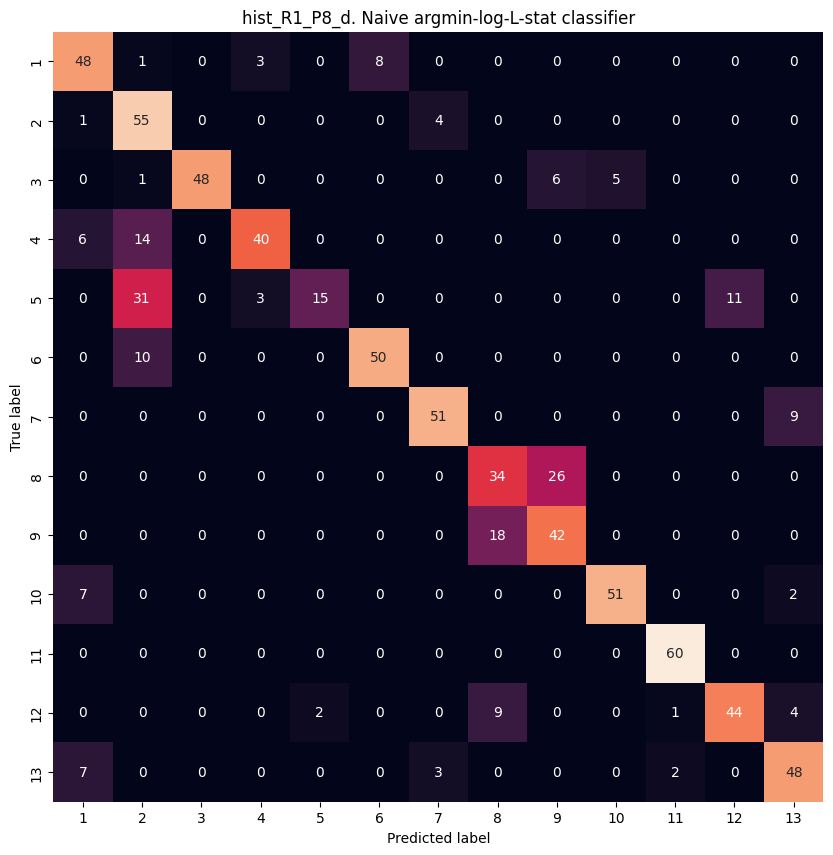

In [171]:
sb.heatmap(confusion, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, square=True, cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.gcf().set_size_inches((10,10))
plt.title(f"{descriptor}. Naive argmin-log-L-stat classifier")

In [172]:
print(f"Balanced accuracy score: {skl.metrics.balanced_accuracy_score(y_test, pred_classes):.3f}")
print(f"F1-score[macro]: {skl.metrics.f1_score(y_test, pred_classes, labels=unique_labels, average='macro'):.3f}")
print(f"F1-score[micro]: {skl.metrics.f1_score(y_test, pred_classes, labels=unique_labels, average='micro'):.3f}")

Balanced accuracy score: 0.751
F1-score[macro]: 0.748
F1-score[micro]: 0.751
